In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Download necessary NLTK data

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saiun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saiun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load the data

In [4]:
file_path = 'reviews (1).csv'
data = pd.read_csv(file_path)
data.head()# Inspect the data

,reviewId,userName,userImage,content,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,0197c118-5c6f-4a7b-894c-970023d1a350,Mar Zur,https://play-lh.googleusercontent.com/a/ACg8oc...,I have the same recurring tasks to do every da...,11,4.16.6.2,22-07-2020 13:13,Our team will be happy to look into it for you...,23-07-2020 16:32,4.16.6.2,most_relevant,com.anydo
1,94868fb5-a21d-4ef9-ab85-81b2ed3d0785,Devin Rivera,https://play-lh.googleusercontent.com/a-/ALV-U...,"Instead of shopping around, I downloaded Any.d...",8,NaN,08-12-2020 06:24,We are not aware of any issues with randomized...,10-12-2020 09:38,NaN,most_relevant,com.anydo
2,825da34e-f65d-4ef3-991d-02d5291820d6,Heidi Kinsley,https://play-lh.googleusercontent.com/a/ACg8oc...,Why does every once in a while... out of the b...,6,5.11.1.2,09-07-2021 13:51,Sorry to hear that! It sounds like you might h...,11-07-2021 11:16,5.11.1.2,most_relevant,com.anydo
3,a49c2875-651a-4c33-b79c-5813780d659e,Daniel Keller,https://play-lh.googleusercontent.com/a/ACg8oc...,Terrible Update! This app used to be perfect f...,5,NaN,16-11-2020 01:50,Please note that the tasks in your tasks view ...,17-11-2020 09:31,NaN,most_relevant,com.anydo
4,9482c75e-2e63-46ab-8c94-47273dd6a829,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app is deceivingly terrible. There are so...,20,4.14.0.4,31-01-2019 16:19,"Hi Ryan, it sounds like you are describing our...",05-02-2019 11:52,4.14.0.4,most_relevant,com.anydo


In [5]:
# Print column names to identify the correct label column
print(data.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion',
       'sortOrder', 'appId'],
      dtype='object')


# Text preprocessing

In [6]:
# Function for text preprocessing
def preprocess_text(text):
    # Lower case
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove new lines
    text = text.replace('\n', ' ')
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text
data.head()

,reviewId,userName,userImage,content,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,0197c118-5c6f-4a7b-894c-970023d1a350,Mar Zur,https://play-lh.googleusercontent.com/a/ACg8oc...,I have the same recurring tasks to do every da...,11,4.16.6.2,22-07-2020 13:13,Our team will be happy to look into it for you...,23-07-2020 16:32,4.16.6.2,most_relevant,com.anydo
1,94868fb5-a21d-4ef9-ab85-81b2ed3d0785,Devin Rivera,https://play-lh.googleusercontent.com/a-/ALV-U...,"Instead of shopping around, I downloaded Any.d...",8,NaN,08-12-2020 06:24,We are not aware of any issues with randomized...,10-12-2020 09:38,NaN,most_relevant,com.anydo
2,825da34e-f65d-4ef3-991d-02d5291820d6,Heidi Kinsley,https://play-lh.googleusercontent.com/a/ACg8oc...,Why does every once in a while... out of the b...,6,5.11.1.2,09-07-2021 13:51,Sorry to hear that! It sounds like you might h...,11-07-2021 11:16,5.11.1.2,most_relevant,com.anydo
3,a49c2875-651a-4c33-b79c-5813780d659e,Daniel Keller,https://play-lh.googleusercontent.com/a/ACg8oc...,Terrible Update! This app used to be perfect f...,5,NaN,16-11-2020 01:50,Please note that the tasks in your tasks view ...,17-11-2020 09:31,NaN,most_relevant,com.anydo
4,9482c75e-2e63-46ab-8c94-47273dd6a829,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app is deceivingly terrible. There are so...,20,4.14.0.4,31-01-2019 16:19,"Hi Ryan, it sounds like you are describing our...",05-02-2019 11:52,4.14.0.4,most_relevant,com.anydo


# Apply preprocessing to the text data

In [7]:
# Replace NaN values in the 'content' column with empty strings
data['content'] = data['content'].fillna("")

# Apply preprocessing to the text data
data['cleaned_text'] = data['content'].apply(preprocess_text)

# Display the original content and cleaned text for the first few rows
data[['content', 'cleaned_text']].head()

,content,cleaned_text
0,I have the same recurring tasks to do every da...,recur task everi day need todolist remind buzz...
1,"Instead of shopping around, I downloaded Any.d...",instead shop around download anydo wide use se...
2,Why does every once in a while... out of the b...,everi blue app ask updat acct email everyth ta...
3,Terrible Update! This app used to be perfect f...,terribl updat app use perfect plan certain tas...
4,This app is deceivingly terrible. There are so...,app deceivingli terribl realli nice design fea...


# Vectorize the text data

In [8]:
# Handle missing values in 'content' column
# Drop rows with missing 'content' values
data = data.dropna(subset=['content'])
# For example, we classify a review as positive (1) if it contains the word 'good', otherwise negative (0)
data['label'] = data['content'].apply(lambda x: 1 if 'good' in x.lower() else 0)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content'])

# Use the created 'label' column as labels
y = data['label']

# Verify the transformation
print(X.shape)
print(y.value_counts())

(16787, 14323)
label
0    14462
1     2325
Name: count, dtype: int64


# Split the dataset

In [9]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize models

In [10]:
# Define models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear')
}

In [11]:
# Define hyperparameters and their ranges for each model
param_grids = {
    "Naive Bayes": {'alpha': [0.1, 1]},
    "Logistic Regression": {'C': [0.1, 1]},
    "Support Vector Machine": {'C': [0.1, 1]}
}


# Train and evaluate models

In [12]:
# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Validate the model
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"{model_name} Validation Accuracy: {val_accuracy * 100:.2f}%")
    
    # Test the model
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")
    
    # Generate classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_test_pred))

Naive Bayes Validation Accuracy: 87.13%
Naive Bayes Test Accuracy: 87.61%

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2188
           1       0.68      0.11      0.19       331

    accuracy                           0.88      2519
   macro avg       0.78      0.55      0.56      2519
weighted avg       0.85      0.88      0.84      2519

Logistic Regression Validation Accuracy: 96.35%
Logistic Regression Test Accuracy: 96.55%

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2188
           1       1.00      0.74      0.85       331

    accuracy                           0.97      2519
   macro avg       0.98      0.87      0.91      2519
weighted avg       0.97      0.97      0.96      2519

Support Vector Machine Validation Accuracy: 99.92%
Support Vector Machine Test Accuracy: 99.80

# Grid Search for Models

In [13]:
# Perform grid search for each model
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters
    print("Best Hyperparameters:", grid_search.best_params_)
    
    # Evaluate the model on the training set
    y_train_pred = grid_search.predict(X_train)
    
    # Print the classification report and confusion matrix for training data
    print("Classification Report (Training Data):")
    print(classification_report(y_train, y_train_pred))
    print("Confusion Matrix (Training Data):")
    print(confusion_matrix(y_train, y_train_pred))
    
    # Evaluate the model on the test set
    y_test_pred = grid_search.predict(X_test)
    
    # Print the classification report and confusion matrix for test data
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix (Test Data):")
    print(confusion_matrix(y_test, y_test_pred))


Model: Naive Bayes
Best Hyperparameters: {'alpha': 0.1}
Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     10093
           1       0.99      0.53      0.69      1657

    accuracy                           0.93     11750
   macro avg       0.96      0.77      0.83     11750
weighted avg       0.94      0.93      0.92     11750

Confusion Matrix (Training Data):
[[10082    11]
 [  774   883]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2188
           1       0.79      0.36      0.49       331

    accuracy                           0.90      2519
   macro avg       0.85      0.67      0.72      2519
weighted avg       0.89      0.90      0.89      2519

Confusion Matrix (Test Data):
[[2157   31]
 [ 213  118]]

Model: Logistic Regression
Best Hyperparameters: {'C': 1}
Classification Report (Training D

# Evaluate the Best Model

In [18]:
# Function to evaluate each model
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_report = classification_report(y_train, y_train_pred)
    val_report = classification_report(y_val, y_val_pred)
    test_report = classification_report(y_test, y_test_pred)
    
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    return {
        "model": model,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "train_report": train_report,
        "val_report": val_report,
        "test_report": test_report,
        "train_conf_matrix": train_conf_matrix,
        "val_conf_matrix": val_conf_matrix,
        "test_conf_matrix": test_conf_matrix
    }

results = []
for model_name, model in models.items():
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
    results.append(result)

# Choose the final model based on performance
best_model = max(results, key=lambda x: x['val_accuracy'])

# Print results for the best model
print("Best Model:", best_model['model'])
print("Training Accuracy: {:.2f}%".format(best_model['train_accuracy'] * 100))
print("Validation Accuracy: {:.2f}%".format(best_model['val_accuracy'] * 100))
print("Test Accuracy: {:.2f}%".format(best_model['test_accuracy'] * 100))
print("\nClassification Report (Training Dataset):")
print(best_model['train_report'])
print("\nClassification Report (Validation Dataset):")
print(best_model['val_report'])
print("\nClassification Report (Test Dataset):")
print(best_model['test_report'])
print("\nConfusion Matrix (Training Dataset):")
print(best_model['train_conf_matrix'])
print("\nConfusion Matrix (Validation Dataset):")
print(best_model['val_conf_matrix'])
print("\nConfusion Matrix (Test Dataset):")
print(best_model['test_conf_matrix'])


Best Model: SVC(kernel='linear')
Training Accuracy: 99.88%
Validation Accuracy: 99.92%
Test Accuracy: 99.80%

Classification Report (Training Dataset):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10093
           1       1.00      0.99      1.00      1657

    accuracy                           1.00     11750
   macro avg       1.00      1.00      1.00     11750
weighted avg       1.00      1.00      1.00     11750


Classification Report (Validation Dataset):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2181
           1       1.00      0.99      1.00       337

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518


Classification Report (Test Dataset):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2188
 

# Data Visualization for Input and Output plots

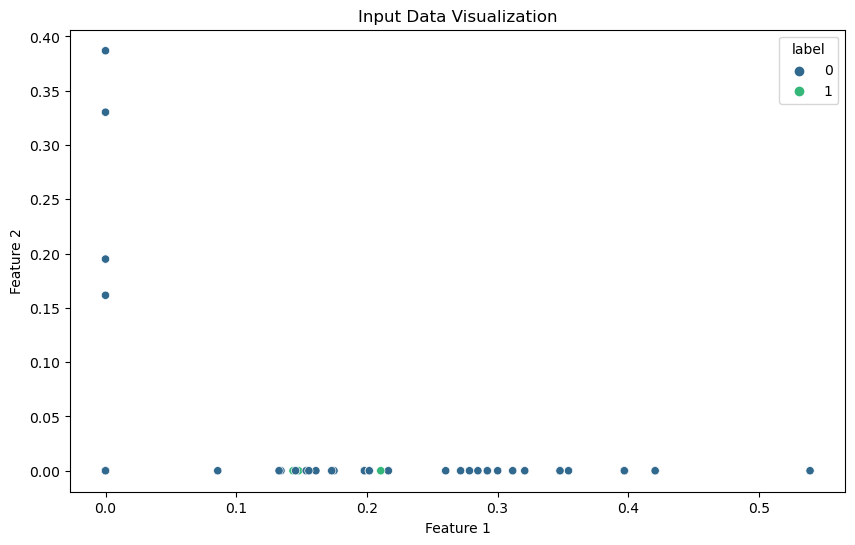

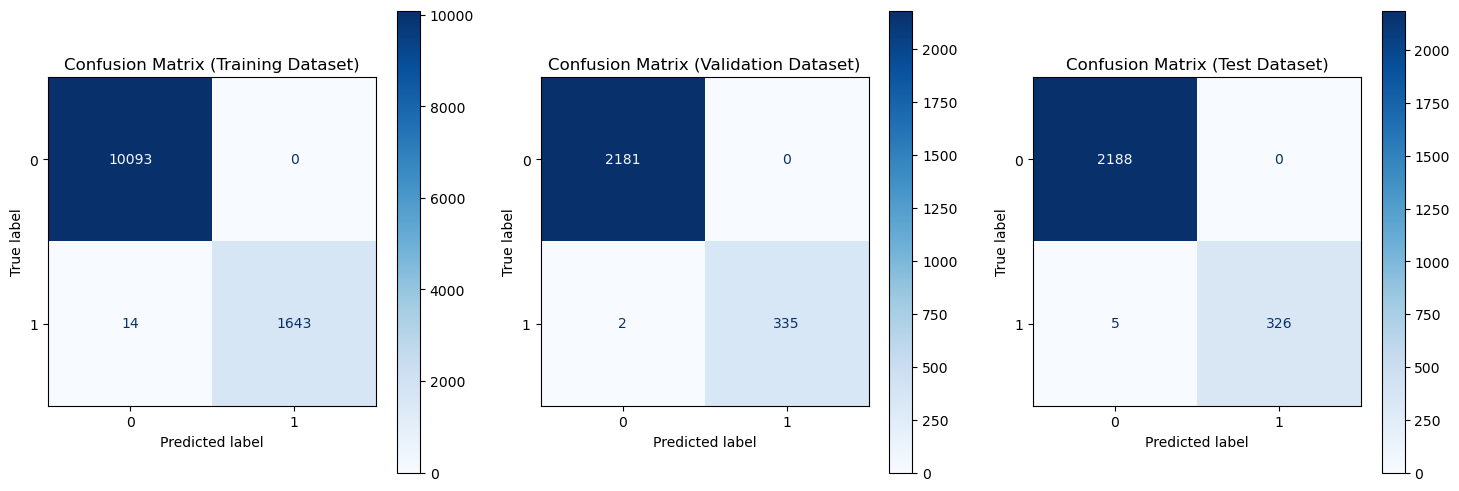

In [31]:
# Convert the sparse matrix to a dense array for visualization
X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train

# Example visualization for input data
def visualize_input_data(X_train, y_train):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette='viridis')
    plt.title('Input Data Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Call the function to visualize input data
visualize_input_data(X_train_dense, y_train)

# Plot confusion matrices using ConfusionMatrixDisplay
def plot_confusion_matrices(best_model_result):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Training dataset confusion matrix
    ConfusionMatrixDisplay(best_model_result['train_conf_matrix']).plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title('Confusion Matrix (Training Dataset)')
    
    # Validation dataset confusion matrix
    ConfusionMatrixDisplay(best_model_result['val_conf_matrix']).plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title('Confusion Matrix (Validation Dataset)')
    
    # Test dataset confusion matrix
    ConfusionMatrixDisplay(best_model_result['test_conf_matrix']).plot(ax=axes[2], cmap='Blues', values_format='d')
    axes[2].set_title('Confusion Matrix (Test Dataset)')
    
    plt.show()

# Evaluate models and collect results
results = []
for model_name, model in models.items():
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
    results.append(result)

# Choose the final model based on performance
best_model_result = max(results, key=lambda x: x['val_accuracy'])

# Call the function to plot confusion matrices
plot_confusion_matrices(best_model_result)


# Plot for best model

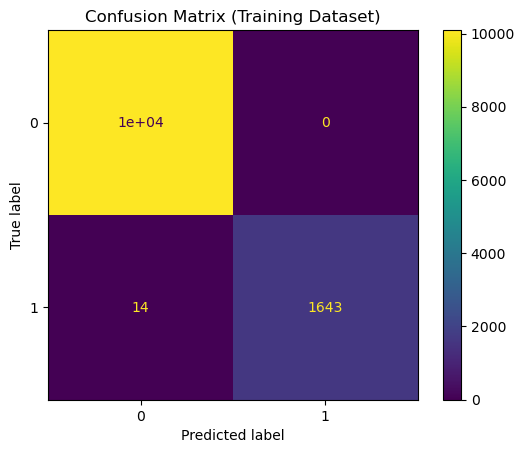

Classification Report (Training Dataset):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10093
           1       1.00      0.99      1.00      1657

    accuracy                           1.00     11750
   macro avg       1.00      1.00      1.00     11750
weighted avg       1.00      1.00      1.00     11750

Accuracy (Training Dataset): 99.88%





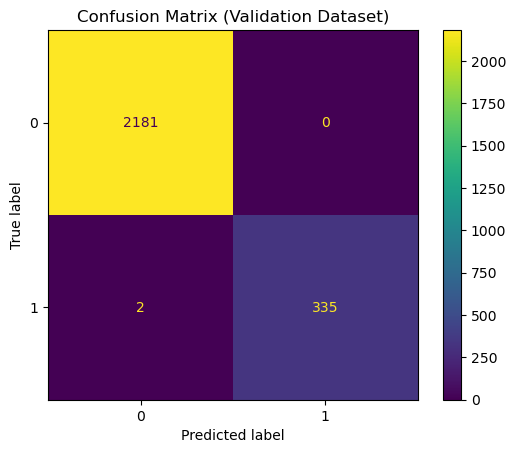

Classification Report (Validation Dataset):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2181
           1       1.00      0.99      1.00       337

    accuracy                           1.00      2518
   macro avg       1.00      1.00      1.00      2518
weighted avg       1.00      1.00      1.00      2518

Accuracy (Validation Dataset): 99.92%





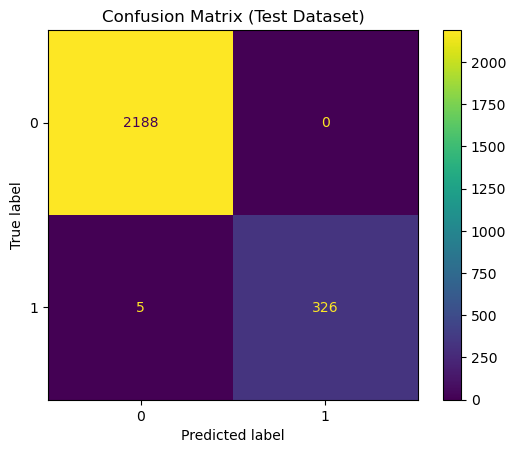

Classification Report (Test Dataset):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2188
           1       1.00      0.98      0.99       331

    accuracy                           1.00      2519
   macro avg       1.00      0.99      1.00      2519
weighted avg       1.00      1.00      1.00      2519

Accuracy (Test Dataset): 99.80%





In [37]:
# Plot output for the best model
def plot_model_output(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Plot output for each dataset
    datasets = [("Training Dataset", X_train, y_train), ("Validation Dataset", X_val, y_val), ("Test Dataset", X_test, y_test)]
    for name, X, y in datasets:
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        report = classification_report(y, y_pred)
        conf_matrix = confusion_matrix(y, y_pred)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
        disp.plot()
        plt.title(f'Confusion Matrix ({name})')
        plt.show()
        
        # Print classification report
        print(f"Classification Report ({name}):")
        print(report)
        print(f"Accuracy ({name}): {accuracy*100:.2f}%")
        print("\n\n")

# Plot output for the best model
plot_model_output(best_model['model'], X_train, y_train, X_val, y_val, X_test, y_test)
